# Assignment 1: Transformations


TEAM-ID: 1   
TEAM-NAME: curiosity   
YOUR-ID: 2018122004  
YOUR-NAME: Shivani Chepuri  

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

# Instructions
- Please check Moodle for "TEAM-ID" and "TEAM-NAME" fields above. Some of your names have been edited because of redundancy/simplicity. Instructions for submitting the assignment through GitHub Classrooms/Moodle has been uploaded on Moodle. Any clarifications will be made there itself.
- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment. See `./misc/installation` for detailed step-by-step instructions about the installation setup.
- Both the team members must submit the zip file.
- For this assignment, you will be using Open3D extensively. Refer to [Open3D Documentation](http://www.open3d.org/docs/release/): you can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
- Take a look at the entire assignment. The descriptive questions at the end might have a clue if you are stuck somewhere.
- Answer the descriptive questions in your own words with context & clarity. Do not just copy-paste from some Wikipedia page. You will be evaluated accordingly.
- Please call the visualization functions only when they are asked. They are asked explicitly at the end of every section.
- You could split the Jupyter Notebook cells where `TODO` is written, but please try to avoid splitting/changing the structure of other cells.

In [2]:
import open3d as o3d
import copy
import numpy as np
from scipy.linalg import logm
from scipy.spatial.transform import Rotation as R
from scipy.optimize import fsolve
from time import sleep 

# 1. Getting started with Open3D
## 1.1 Converting RGBD image into Point Cloud


In your robotics journey, it is common to be given just the depth images along with camera parameters in a generic dataset and you'd want to build a 3D data representation out of it, for example, a point cloud. You will understand the math behind these concepts in detail during Vision classes, for now, you can use the in-built functions as a black box.
- Below are the given RGB and D images from SUN RGB-D dataset ([S.Song, CVPR 2015](https://rgbd.cs.princeton.edu/)). 
![low-res-RGBD.resized.png](./misc/low-res-RGBD.png)

- Read these two images `color.jpg` and `depth.png` given in current folder using Open3D. Convert it to a point cloud using the default camera parameters (`o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault`).
Then,
- Create a "world" frame $A$ and combine this (just use $+$ operator) with the above point cloud and save it as `scene.pcd`. Put it aside for now.
- Write a simple function `one_one` to visualize `scene.pcd`.

In [3]:
##############################################################################
# TODO: Do tasks described in 1.1                                            #
##############################################################################
# Replace "pass" statement with your code
#pass
from matplotlib import pyplot as plt 
def one_one():
    color_raw = o3d.io.read_image("color.jpg")
    depth_raw = o3d.io.read_image("depth.png")
    rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
            color_raw, depth_raw)
    print(rgbd_image)

    plt.subplot(1, 2, 1)
    plt.title('SUN grayscale image')
    plt.imshow(rgbd_image.color)
    plt.subplot(1, 2, 2)
    plt.title('SUN depth image')
    plt.imshow(rgbd_image.depth)
    plt.show()

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image,
            o3d.camera.PinholeCameraIntrinsic(
                o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    # o3d.visualization.draw_geometries([pcd])


    #Creating World Frame
    worldframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=([0.0, 0.0, 0.0]))
    worldpcd = worldframe.sample_points_uniformly(number_of_points=500)


    scenepcd = worldpcd + pcd
    o3d.io.write_point_cloud("scene.pcd", scenepcd)
    scene = o3d.io.read_point_cloud("scene.pcd")
    o3d.visualization.draw_geometries([scene])

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### Question for 1.1

- In the next code cell, call the function `one_one` here showing `scene.pcd`.

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


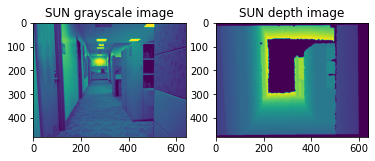

In [4]:
#uncomment the following and add input parameters if any
one_one()

# 2. Rotations, Euler angles and Gimbal Lock

## 2.1 Rotating an object

The objective here is to roughly simulate an object moving on a ground.

- Generate a cube at some point on the ground and create another frame $B$ at the center of this object. Combine these both as a single point cloud `cube.pcd`. (You can pick a point on the ground by using the `get_picked_points` method of the class `open3d.visualization.VisualizerWithEditing`.)
- Now read both the point clouds `scene.pcd` and `cube.pcd` in a script. Whatever tasks you do below are on the object `cube.pcd` (along with the axes $B$) with `scene.pcd` in the background (static).
- Given a sequence of **ZYX Euler** angles $[30^{\circ}, 90^{\circ}, 45^{\circ}]$, generate the rotation. In our case, our object (with its respective axis) undergoes rotation with the background being fixed (with its respective axis).
- Note: Throughout this assignment, we will be using the standard **ZYX** Euler angle convention.
- Write a function `two_one` to show the above by **animation** (cube rotating along each axis one by one).
    - *Hint: Use Open3D's non-blocking visualization and discretize the rotation to simulate the animation. For example, if you want to rotate by $30^{\circ}$ around a particular axis, do in increments of $5^{\circ}$ 6 times to make it look like an animation.*

In [5]:
##############################################################################
# TODO: Do tasks described in 2.1                                            #
##############################################################################
def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press q for close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

scene = o3d.io.read_point_cloud("scene.pcd")
ground_point_id = pick_points(scene)[0]


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press q for close the window
[Open3D INFO] Picked point #116915 (0.66, -0.1, -2.7) to add in queue.



In [31]:
def to_rotm_zyx(arr):
    #a, b, g - euler angles
    a = arr[0]
    b = arr[1]
    g = arr[2]

    r11 = np.cos(a)*np.cos(b)
    r12 = np.cos(a)*np.sin(b)*np.sin(g) - np.sin(a)*np.cos(g)
    r13 = np.cos(a)*np.sin(b)*np.cos(g) + np.sin(a)*np.sin(g)

    r21 = np.sin(a)*np.cos(b)
    r22 = np.sin(a)*np.sin(b)*np.sin(g) + np.cos(a)*np.cos(g)
    r23 = np.sin(a)*np.sin(b)*np.cos(g) - np.cos(a)*np.sin(g)

    r31 = -np.sin(b)
    r32 = np.cos(b)*np.sin(g)
    r33 = np.cos(b)*np.cos(g)

    Rmat = [[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]]

    return Rmat

def animation(vis,cube,pcd,center,z_angle,y_angle,x_angle):
    vis.add_geometry(cube)
    T = np.eye(4)
    
    anim_angle = 0.05
    
    iterZ = z_angle/anim_angle
    iterY = y_angle/anim_angle
    iterX = x_angle/anim_angle
    
    
    arr = [anim_angle,0,0]
    rot_matZ = np.array(to_rotm_zyx(arr))
    arr = [0,anim_angle,0]
    rot_matY = np.array(to_rotm_zyx(arr))
    arr = [anim_angle,0,0]
    rot_matX = np.array(to_rotm_zyx(arr))
    
    

    while iterZ>=0:
        
        rot_matZ = o3d.geometry.get_rotation_matrix_from_zyx([anim_angle,0,0])
#       print(iterZ)
        cube.rotate(rot_matZ, center=center)
        vis.update_geometry(cube)
        vis.poll_events()
        vis.update_renderer()
        sleep(1.0)
        iterZ-=1
    
    
    while iterY>=0:
        
        total_rot_matZ = R.from_euler('ZYX', [30, 0, 0], degrees=True)
        total_rot_matZ = total_rot_matZ.as_matrix()
        unitY = np.array([0, 1, 0]).reshape(3,1)
        Rmat = np.array(total_rot_matZ)
        Axisy = Rmat @ unitY                     
                     
        rot = o3d.geometry.get_rotation_matrix_from_axis_angle(Axisy*anim_angle)
        cube.rotate(rot, center=center)
        vis.update_geometry(cube)
        vis.poll_events()
        vis.update_renderer()
        sleep(1.0)
        iterY-=1
    

    while iterX>=0:
        unitX = np.array([1, 0, 0]).reshape(3,1)
        total_rot_matY = R.from_euler('ZYX', [30, 90, 0], degrees=True)
        total_rot_matY = total_rot_matY.as_matrix()
        RmatX = np.array(total_rot_matY)
        AxisX = RmatX @ unitX
      
        rot = o3d.geometry.get_rotation_matrix_from_axis_angle(AxisX*anim_angle)

        cube.rotate(rot, center=center)
        vis.update_geometry(cube)
        vis.poll_events()
        vis.update_renderer()
        sleep(1.0)
        iterX-=1
    vis.destroy_window()   

    
    
def two_one(z_angle,y_angle,x_angle):
    gnd_pt_coord = scene.points[ground_point_id]
    cube = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
    cube.paint_uniform_color([0.0, 0.8, 0.0])
    cubepcd = cube.sample_points_uniformly(number_of_points=5000)

    cube_at_pt = cubepcd.translate(gnd_pt_coord)
    center = o3d.geometry.Geometry3D.get_center(cube_at_pt)

    #Creating cube Frame
    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=([0.0, 0.0, 0.0]))
    framepcd = frame.sample_points_uniformly(number_of_points=500)
    framepcdt = framepcd.translate(center)
                     
    pcd = framepcdt + scene                
    


    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    

    animation(vis,framepcdt + cube_at_pt,pcd,center,z_angle,y_angle,x_angle)
    
    
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### Question for 2.1

- In the next code cell, call the function `two_one` here showing the animation described in section 2.1.

In [32]:
#uncomment the following and add input parameters if any
two_one(0.523599,1.5708,0.785398)

[Open3D DEBUG] Add geometry and update bounding box to [(-1.4275, -1.0173, -6.8890) - (2.2767, 2.3029, 0.9594)]
[Open3D DEBUG] Add geometry and update bounding box to [(-1.4275, -1.0173, -6.8890) - (2.2767, 2.3029, 0.9594)]


## 2.2 Euler angle & Gimbal lock

Code the following yourself from scratch (Refer Craig book - Section: $Z-Y-X$ Euler angles - same conventions/notations followed).

- Case 1: Given the rotation matrix $M_{given}$ below, extract Euler angles $\alpha , \beta ,\gamma$. Convert it back to the rotation matrix $M_{recovered}$ from Euler angles.

    $$M(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0.26200263 & -0.19674724 & 0.944799 \\0.21984631 & 0.96542533 & 0.14007684 \\
    -0.93969262 & 0.17101007 & 0.29619813\end{array}\right] $$

    After coding it from scratch, check your calculations using `scipy.spatial.transform.Rotation`. (Mandatory)

- Case 2: Given the rotation matrix $N_{given}$, extract Euler angles, and convert back $N_{recovered}$.

    $$N(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0 & -0.173648178 &  0.984807753 \\0 & 0.984807753 & 0.173648178 \\
    -1 & 0 & 0\end{array}\right] $$

    Again use `scipy` and check its output. If `scipy` is showing any warnings on any of the above cases, explain it in "**Questions for 2.2**" (last question). Write code in the next cell.
    
- (Optional) Case 3: Do the above two for quaternion using scipy functions, i.e. given the rotation matrix, extract quaternion and convert back.

In [33]:
##############################################################################
# DON'T EDIT
M_given =  np.array([[0.26200263, -0.19674724, 0.944799],
                     [0.21984631, 0.96542533, 0.14007684],
                     [-0.93969262, 0.17101007, 0.29619813]])

N_given = np.array([[0,-0.173648178,0.984807753],
                    [0, 0.984807753, 0.173648178],
                    [-1, 0, 0]])

In [34]:
# TODO: Do tasks described in 2.2                                            #
##############################################################################
# Replace "pass" statement with your code

def to_euler_zyx(R):
# R = [r11,r12,r13;r21,r22,r23;r31,r32,r33];
# a, b, g - euler angles

    r11 = R[0,0]
    r12 = R[0,1]
    r13 = R[0,2]

    r21 = R[1,0]
    r22 = R[1,1]
    r23 = R[1,2]

    r31 = R[2,0]
    r32 = R[2,1]
    r33 = R[2,2]

    term1 = np.sqrt(np.power(r11,2) + np.power(r21,2))

    # Check Gimbal
    if  term1 > 1e-6 :
        a = np.arctan2(r21, r11) #alpha
        b = np.arctan2(-r31, term1) #beta
        g = np.arctan2(r32 , r33) #gamma
    
    else :
        a = 0
        b = np.arctan2(-r31, term1)
        g = np.arctan2(-r23, r22)
        #g = np.arctan2(r32 , r33)
    #a = np.degrees(a)
    #b = np.degrees(b)
    #g = np.degrees(g)

    #angles = np.rad2deg([a, b, g])
    angles = np.array([a,b,g])
    return angles

def to_rotm_zyx(arr):
    #a, b, g - euler angles
    #arr = np.rad2deg(arr)
    a = arr[0]
    b = arr[1]
    g = arr[2]
    #a = np.degrees(a)
    #b = np.degrees(b)
    #g = np.degrees(g)

    r11 = np.cos(a)*np.cos(b)
    r12 = (np.cos(a)*np.sin(b)*np.sin(g)) - (np.sin(a)*np.cos(g))
    r13 = (np.cos(a)*np.sin(b)*np.cos(g)) + (np.sin(a)*np.sin(g))

    r21 = np.sin(a)*np.cos(b)
    r22 = (np.sin(a)*np.sin(b)*np.sin(g)) + (np.cos(a)*np.cos(g))
    r23 = (np.sin(a)*np.sin(b)*np.cos(g)) - (np.cos(a)*np.sin(g))

    r31 = -np.sin(b)
    r32 = (np.cos(b)*np.sin(g))
    r33 = (np.cos(b)*np.cos(g))

    Rmat = [[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]];

    return Rmat
#-------------------------M_given----------------------
a_M = to_euler_zyx(M_given)
b_M = np.array(to_rotm_zyx(a_M))

#r1 = R.from_matrix('zyx', M, degrees=True)
r1 = R.from_matrix(M_given)
r2 = r1.as_euler('ZYX', degrees=False)
rqm = r1.as_quat()

r3 = R.from_euler('ZYX', r2, degrees=False)
r4 = r3.as_matrix()

r_qm = R.from_quat(rqm)
r_qm_rmat = r_qm.as_matrix()

print("-------------------------case 1------------------------")
print("Using Defined Function")
print("Rotation Matrix to Euler Angles in Radians")
print(a_M)
print("\n")

print("Using Defined Function")
print("Euler Angles to Rotation Matrix in Radians")
print(b_M)
print("\n")

print("Using Scipy transform.Rotation")
print("Rotation Matrix to Euler Angles in Radians")
print(r2)
print("\n")

print("Using Scipy transform.Rotation")
print("Euler Angles to Rotation Matrix in Radians")
print(r4)
print("\n")

print("Using Scipy transform.Rotation")
print("Rotation Matrix to Quaternion")
print(rqm)
print("\n")

print("Using Scipy transform.Rotation")
print("Quaternion to Rotation Matrix")
print(r_qm_rmat)
print("\n")

#-----------------------N_given------------------------
a_N = to_euler_zyx(N_given)
b_N = np.array(to_rotm_zyx(a_N))

#r1 = R.from_matrix('zyx', M, degrees=True)
r1n = R.from_matrix(N_given)
r2n = r1n.as_euler('zyx', degrees=False)
rqn = r1n.as_quat()

r3n = R.from_euler('zyx', r2n, degrees=False)
r4n = r3n.as_matrix()

r_qn = R.from_quat(rqn)
r_qn_rmat = r_qn.as_matrix()

print("-------------------------case 2------------------------")
print("Using Defined Function")
print("Rotation Matrix to Euler Angles in Radians")
print(a_N)
print("\n")

print("Using Defined Function")
print("Euler Angles to Rotation Matrix in Radians")
print(b_N)
print("\n")

print("Using Scipy transform.Rotation")
print("Rotation Matrix to Euler Angles in Radians")
print(r2n)
print("\n")

print("Using Scipy transform.Rotation")
print("Euler Angles to Rotation Matrix in Radians")
print(r4n)
print("\n")

print("Using Scipy transform.Rotation")
print("Rotation Matrix to Quaternion")
print(rqn)
print("\n")

print("Using Scipy transform.Rotation")
print("Quaternion to Rotation Matrix")
print(r_qn_rmat)
print("\n")

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################


-------------------------case 1------------------------
Using Defined Function
Rotation Matrix to Euler Angles in Radians
[0.6981317  1.22173048 0.52359878]


Using Defined Function
Euler Angles to Rotation Matrix in Radians
[[ 0.26200263 -0.19674724  0.944799  ]
 [ 0.21984631  0.96542534  0.14007684]
 [-0.93969262  0.17101007  0.29619813]]


Using Scipy transform.Rotation
Rotation Matrix to Euler Angles in Radians
[0.69813171 1.22173048 0.52359878]


Using Scipy transform.Rotation
Euler Angles to Rotation Matrix in Radians
[[ 0.26200263 -0.19674724  0.944799  ]
 [ 0.21984631  0.96542534  0.14007684]
 [-0.93969262  0.17101007  0.29619813]]


Using Scipy transform.Rotation
Rotation Matrix to Quaternion
[0.00973605 0.59313249 0.13112033 0.79429624]


Using Scipy transform.Rotation
Quaternion to Rotation Matrix
[[ 0.26200263 -0.19674724  0.944799  ]
 [ 0.21984631  0.96542534  0.14007684]
 [-0.93969262  0.17101007  0.29619813]]


-------------------------case 2------------------------
Usin

## Questions for 2.2
- Have you used `np.arctan` or an any equivalent `atan` function above? Why or why not?   
    * Ans: *When we solve for the euler angles i.e, [a,b,g] the expressions are all in atan form. Therefore, it is necessary to use an atan function to obtain arctan(y/x). We have used np.arctan2(y,x). It is better than np.arctan(y/x) as, <br /> 
    
    It is more stable (It can handle $x = 0, \: x < 0$ and $y = 0$, undefined at $x = 0\: and\: y = 0$)<br />
    np.arctan returns 'nan' in some of these cases. Basically, arctan handles a subset of cases handled by arctan2. <br />
    
    Theoretically, the range of all our rotations is 0 to 360 degrees; np.arctan2 gives values from -180 to 180 degrees(covering total range), whereas arctan gives values from -90 to 90 degrees. <br />
    
     arctan2 takes two arguments and arctan takes one. Due to this, arctan2 can explicitly consider the position and sign of the input with respect to the quadrants. <br />
     
     It outputs the atan value indicating its quadrant (signed angle). This requires knowledge of the signs of x and y separately, which is information lost when y is divided by x in case of np.arctan.*

### For Case 1 above,
- What Euler angles  $\alpha , \beta ,\gamma$ did you get? Replace `my_array_case1` with your array.

In [35]:
# Uncomment and replace my_array_case1 with your array.
print("My Euler angles for case 1 are" + str(a_M))
print("The angles are in radians")

My Euler angles for case 1 are[0.6981317  1.22173048 0.52359878]
The angles are in radians


  - Were you able to recover back your rotation matrix when you converted it from Euler angles? Why/why not? Replace `M_given` and `M_recovered` with your matrices below and explain "why/why not" after this code snippet.

In [36]:
# Uncomment and Replace M_given and M_recovered with your matrices below.
error = np.linalg.norm(logm(M_given @ b_M.T))
print("For case 1, it is " + str(error<0.0001) + " I could recover the original matrix.")

For case 1, it is True I could recover the original matrix.


- Why/why not? Based on your observations here, is there any problem with Euler angle representation for Case 1? If yes, what is it?

    - Ans:    *In case 1, the magnitues of $\alpha , \beta ,\gamma$ are all equal. If we consider 'zyx'(intrinsic angles) in as_euler(), we can see that the gamma angle obtained is a bit different from that of scipy, therefore rotation matrix is also a bit different. It is because scipy considers extrinsic angles. When 'ZYX' is specified in as_euler()(extrinsic angles) the euler angles from our defined function and scipy produce the same rotation matrix. Other than this, there was no problem or confusion. 

### Repeat the above for Case 2.

In [37]:
# Uncomment and Replace N_given and N_recovered with your matrices below.
print("My Euler angles for case 2 are" + str(a_N))
print("Angles are in Radians")
error = np.linalg.norm(logm(N_given @ b_N.T))
print("For case 2, it is " + str(error<0.0001) + " I could recover the original matrix.")

My Euler angles for case 2 are[ 0.          1.57079633 -0.17453293]
Angles are in Radians
For case 2, it is True I could recover the original matrix.


* Why/why not? Based on your observations here, is there any problem with Euler angle representation for Case 2? If yes, what is it?

    * Ans: *When our defined functions are used to obtain euler angles for N_given, we get $\alpha = 0$. Therefore, recovering the rotation matrix from the euler angles also gave a different answer. This is due to gimbal lock problem in Euler angle representations $\left(zyx, xyz, etc\right)$. In this case, scipy raises a warning(in general, but nothing of that sort happened for this example). Scipy could clearly overcome the problem with Euler Angle Representation and did not drop the alpha angle. When $\beta = \frac{\pi}{2} \:or\: \beta = -\frac{\pi}{2}$, the rotation matrix reduces to terms with $\sin(\gamma + \alpha)$ and such terms. Changing the values of $\alpha$ and $\gamma$  in the above matrix has the same effects: the rotation angle $\alpha +\gamma$  changes, but the rotation axis remains in the $Z$ direction: the last column and the first row in the Rotation matrix don't change. The problem therefore was not being able to match answers with scipy.* 
    
    
* Explain any more problems with Euler angle representation. Explain what you understand by Gimbal lock (concisely in your own words). You could revisit this question in the section 2.4.
    * Ans: *Gimbal Lock is a problem where the representation loses a degree of freedom and it is not possible to determine the first and third angles uniquely. One of the angles is set to zero. Therefore, recovery of the rotation matrix will not be possible (due to the loss of a value). Basically, In a 3-Gimbal Mechanism, if two of the three Gimbals become parallel(get in the same plane), the system enters into a rotation in a 2D space(degenerated 3D) and we cannot accommodate the rotation of one of the axes (as one value is lost). That means changes accross that axis cannot be compensated anymore. In air-crafts, etc it can generally happen when pitch is +90 or -90 degrees, where yaw and roll angles cannot be distinguished or determined uniquely.*

- When you used `scipy.spatial.transform.Rotation` for the above 2 cases,
    - Have you used `zyx` above in `r.as_euler('')` argument? Why or why not? Explain the difference between extrinsic and instrinsic rotations with equivalent technical names from Craig book?
        * Ans: *No we have used 'ZYX' as argument in the above question. It is necessary to specify the representation of Euler Angles to be generated. 'ZYX' indicate Intrinsic Rotations, whereas 'zyx' indicate extrinsic rotations. We defined Euler Angles with respect to Instrinsic Rotations itself(although extrinsic and intrinsic transformations are possible), therefore it seemed fit to use 'ZYX'. Also, when 'zyx' is used, not all values agreed with each other(scipy defaultly uses uses Intrinsic Angles). Intrinsic rotations apply to axis in rotated coordinate system. Coordinate system of next rotation will be relative to the previous rotation.Extrinsic rotations apply to axis in world coordinate system. Coordinate system of the next rotation will be relative to the (fixed) world coordinate system.*     
   
    - Has `scipy` shown any warnings on any of the above cases? If yes, explain it.
        * Ans: *When using np.arctan instead of np.arctan2, scipy was showing Runtime Warnings viz, 'invalid value encountered in double_scalars' and 'divide by zero encountered in double_scalars'. This is in case 2. There were no warnings in case 1. There were no warnings in both cases, when arctan2 is used. This is because of the drawback in using arctan function, which cannot handle a few input cases(as described in a previous question). Scipy did not show any particular warning in case 2(when we faced gimbal lock) but it did drop a Degree of Freedom.*
    - (Optional) For Case 3 above (quaternion) which you did using scipy, did you observe any problem with quaternion? Depending on your observations, which is better? Quaternion or Euler angles? And why?
         * Ans: *There were no problems with Quaternion, on both the cases. In both cases, Matrix to Quat and Quat to Matrix happened without any errors and the answers were tallied. Quaternion Transformatoin was able to handle case 2 but Euler was not. Quaternion is better as it has no problem with Gimbal Lock unlike Euler. However, Euler angles do have one advantage over Quaternions: Euler angles can tell us the direction and magnitude of a rotation. When we convert a Euler angle to a Quaternion, that information is lost.The gimbal lock problem does not make Euler angles "invalid" (they always serve as a well-defined coordinate system), but it makes them unsuited for some practical applications. So, pros and cons.*


## 2.3 Rotation matrix as an Operator
This question will help you in your understanding of [Rotator-transform (Vector-frame) equivalence](https://www.notion.so/saishubodh/Lecture-2-Transformations-11d69d8cef2d4cd195a98fa7d33224e1#f90ece4f5e374743bfed47e46a83ecfe).

![image.png](./misc/xyz-frame.png)
Consider the frame $XYZ$ in the above image. Say you have a vector $x_1=[0,\sqrt{3},0]$. Now you want to rotate it such that you end up at $x_2=[1,1,1]$ through a sequence of Euler angle rotations. Your goal is to find out those $\alpha, \beta \: \& \: \gamma$ ($ZYX$). We will follow this order whenever we refer to it below.

First, properly understand the so-called "Rotator-transform equivalence" to figure out what are the terms of rotation matrix. Then, put the math on paper and you will end up with a set of non-linear equations. Write the set of linear equations in LaTeX here:

$$ \textbf{Ans: Your set of equations here} $$

Given $^A P$ and $^B P$, we want to find $\alpha$, $\beta$ and $\gamma$ from ${}_{B}^{A} R$, in $Z-Y-X$ Euler Angles 

$^A P={}_{B}^{A} R \: \: ^B P$

$^A P= [1,1,1]^{T} \:\:\: ^B P= [0,\sqrt{3},0]^{T}$

We know that

$\underset{B}{^A} R=\left[\begin{array}{cccc}c\alpha c\beta & c\alpha s\beta s\gamma - s\alpha c\gamma & c\alpha s\beta c\gamma + s\alpha s\gamma \\ s\alpha c\beta & s\alpha s\beta s\gamma + c\alpha c\gamma & s\alpha s\beta c\gamma - c\alpha s\gamma  \\-s\beta & c\beta s\gamma & c\beta c\gamma \end{array}\right]$

$\left[\begin{array}{c}1 \\1 \\1\end{array}\right] = \left[\begin{array}{cccc}c\alpha c\beta & c\alpha s\beta s\gamma - s\alpha c\gamma & c\alpha s\beta c\gamma + s\alpha s\gamma \\ s\alpha c\beta & s\alpha s\beta s\gamma + c\alpha c\gamma & s\alpha s\beta c\gamma - c\alpha s\gamma  \\-s\beta & c\beta s\gamma & c\beta c\gamma \end{array}\right] \left[\begin{array}{c}0 \\\sqrt{3} \\0\end{array}\right]$

Simplifying the above equaiton, we have a system of three non-linear equations with three unknows, $\alpha, \beta, \gamma$

$\left(\cos\alpha \sin\beta \sin\gamma - \sin\alpha \cos\gamma\right)\:\sqrt{3} = 1$

$\left(\sin\alpha \sin\beta \sin\gamma - \cos\alpha \cos\gamma\right)\:\sqrt{3} = 1$

$\cos\beta \sin\gamma \: \sqrt{3} = 1$

$$\cos\alpha \sin\beta \sin\gamma - \sin\alpha \cos\gamma - \frac{1}{\sqrt{3}} = 0$$
$$\sin\alpha \sin\beta \sin\gamma - \cos\alpha \cos\gamma - \frac{1}{\sqrt{3}} = 0$$
$$\cos\beta \sin\gamma - \frac{1}{\sqrt{3}} = 0$$

Solve these equations using `fsolve` from `scipy.optimize` as follows: (Come back and answer the following questions after coding it in the next block)
- `case1`: First, solve it with an initialization of (0,0,0). Check if your answer is correct using `np.isclose`.
    * What Euler angles did you get? Answer in $\alpha, \beta \: \& \: \gamma$ format:
        * Ans: *$a_1, b_1, c_1$ = [ -0.39780642 -93.75690197   0.71372205] (in radians).* 
- `case2`: Now, forget about the solver for a moment: Can you visualize and think of sequence of rotations one by one to reach the final position (which is different than previous set of rotations)? Now, validate your answer by giving (your answer $\pm 5$) as initialization.
    * What Euler angles did you get? Answer in $\alpha, \beta \: \& \: \gamma$ format:
        * Ans: *$a_2, b_2, c_2$ = [0.47829566 0.93255509 1.32139354]*

In [38]:
##############################################################################
# DON'T EDIT
x_1 = np.array([0,np.sqrt(3),0])
x_2 = np.array([1,1,1])

In [39]:
##############################################################################
# TODO: Do tasks described in 2.3                                            #
##############################################################################
# Replace "pass" statement with your code

#x = [a,b,g] angles
def func_eqs(x):
    A = [np.cos(x[0])*np.sin(x[1])*np.sin(x[2]) - np.sin(x[0])*np.cos(x[2]) - (1/np.sqrt(3)),
         np.sin(x[0])*np.sin(x[1])*np.sin(x[2]) + np.cos(x[0])*np.cos(x[2]) - (1/np.sqrt(3)),
         np.cos(x[1])*np.sin(x[2]) - (1/np.sqrt(3))]
    return A

root_1 = fsolve(func_eqs, [0,0,0])

#Guess is [a,b,g] = [45,45,45] degrees
#Initialising [a,b,g] = [40,50,40] degrees
root_2 = fsolve(func_eqs, [0.698132, 0.872665, 0.698132])
print(np.rad2deg(np.array(root_2)))
print(np.rad2deg(np.array(root_1)))

print("The obtained Euler Angles in Radians are:")
print((0,0,0), "initialization: ", "root_1 = ", root_1)
print((40,50,40),"deg", "initialization: ", "root_2 = ", root_2)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

[27.40432087 53.43147076 75.71027168]
[  -22.79262916 -5371.87478296    40.89326103]
The obtained Euler Angles in Radians are:
(0, 0, 0) initialization:  root_1 =  [ -0.39780642 -93.75690197   0.71372205]
(40, 50, 40) deg initialization:  root_2 =  [0.47829563 0.93255509 1.32139352]


In [40]:
# From Section 2.2, use the function which takes Euler angles and gives Rotation matrix as output.
# Uncomment and replace `r_mat` with the name of the function. (Do NOT edit anything else)
x_2_obtained_case1 = to_rotm_zyx(root_1) @ x_1.T #TODO: replace r_mat
x_2_obtained_case2 = to_rotm_zyx(root_2) @ x_1.T #TODO: replace r_mat
test = True #TODO: Set this as True

print(x_2_obtained_case1)
print(x_2_obtained_case2)

[1. 1. 1.]
[1. 1. 1.]


In [41]:
# DON'T EDIT
if test == True:
    case1_test = np.isclose(x_2_obtained_case1,  np.array([1.0,1.0,1.0]))
    case2_test = np.isclose(x_2_obtained_case2,  np.array([1.0,1.0,1.0]))
    print("For case 1, it is " + str(bool(case1_test[0] and case1_test[1] and case1_test[2])) + 
          " that I could end up at (1,1,1) after rotation.")
    print("For case 2, it is " + str(bool(case2_test[0] and case2_test[1] and case2_test[2])) + 
          " that I could end up at (1,1,1) after rotation.")

For case 1, it is True that I could end up at (1,1,1) after rotation.
For case 2, it is True that I could end up at (1,1,1) after rotation.


## 2.4 Gimbal Lock visualization (Optional)

A nice visualization video for gimbal lock is [this](https://www.youtube.com/watch?v=zc8b2Jo7mno). You are about to animate a similar visualization demonstrating gimbal lock 😃.

![image.png](./misc/xyz-frame.png)

- Write a function `two_four` for the visualization of gimbal lock. Follow the below steps to get the intuition going. Use Open3D for the following.
    - Say our frame's initial position is as the above image. Now the final goal at the end of rotation is to get the $Y$ axis pointing in the direction of the vector $(x,y,z)$ that you currently see in the above image. This point is fixed in space and is NOT moving as we rotate our axis.
    - For creating that point, you could use a small sphere using `open3d.geometry.create_mesh_sphere`. You already know how to create an axis by now.
    - Following our $ZYX$ convention, first rotate your frame about $Z$ axis by an angle, say $-35^{\circ}$. Then rotate about $Y$ axis by an angle ${\beta}$ and then about $X$ by say $55^{\circ}$.
        - Are there any specific angle(s) $\beta$ using which you will **never** reach our point $(x,y,z)$ ?
            - Clue: We are specifically talking about gimbal lock here and notice the word "never".
        - Under this (these) specific angle(s) of $\beta$ & different combinations of $\alpha$ and $\gamma$, make an animation and clearly show why your $Y$ axis is unable to align in the direction of that vector $(x,y,z)$ using the animation.

            If you are unsure to simulate the animation, you could do it as follows:

            - You could first fix some $\alpha$, say $-35^{\circ}$ & an above value of $\beta$, you can now vary $\gamma$ from $-180^{\circ} \text{ to }180^{\circ}$ to simulate the animation.
            - Now fix another $\alpha$, say $45^{\circ}$ and repeat the above process. So that's 2 specific values of $\alpha$.
            - Show this for all angles of $\beta$ if there are more than 1.
            - Therefore, when the code is run, there should be a minimum of (2 $\times$ (number of values of $\beta$)) animations. 2 for values of $\alpha$, you could show it for even more if you wish to.

In [ ]:
##############################################################################
# TODO: Do tasks described in 2.4                                            #
##############################################################################
# Replace "pass" statement with your code

mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1, resolution=1)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size = 2, origin = [0, 0, 0])


mesh_r = copy.deepcopy(mesh_frame)
R = mesh_frame.get_rotation_matrix_from_zyx((0,0,-7*np.pi/36))
mesh_r.rotate(R, center = True)
o3d.visualization.draw_geometries([mesh_frame, mesh_r])

#Gimbal can occur for a = -35, b = 90, c = 55
beta = np.pi/2
mesh_r = copy.deepcopy(mesh_frame)
R = mesh_frame.get_rotation_matrix_from_zyx((0,beta,0))
mesh_r.rotate(R, center = True)
o3d.visualization.draw_geometries([mesh_frame, mesh_r])

mesh_r = copy.deepcopy(mesh_frame)
R = mesh_frame.get_rotation_matrix_from_zyx((11*np.pi/36,0,0))
mesh_r.rotate(R, center = True)
o3d.visualization.draw_geometries([mesh_frame, mesh_r])




#point = [2,3,4]
#point_cloud = o3d.geometry.PointCloud(point)
mesh_frame_aboutZ = copy.deepcopy(mesh_frame).rotate((1.3,0,0))
#mesh_ty = copy.deepcopy(mesh_frame).translate((0,1.3,0))
print(f'Center of mesh: {mesh_frame.get_center()}')
print(f'Center of mesh tx: {mesh_tx.get_center()}')
print(f'Center of mesh ty: {mesh_ty.get_center()}')
o3d.visualization.draw_geometries([mesh_frame, mesh_tx, mesh_ty, mesh_sphere])
#o3d.visualization.draw_geometries([mesh_sphere, mesh_frame, point_cloud])










##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

> VOILA! You have just animated the famous Gimbal lock problem. If you are curious, read about the [Apollo 11](https://en.wikipedia.org/wiki/Gimbal_lock#On_Apollo_11) Gimbal lock incident.

### Questions for 2.4 (Optional)

- Mention the value(s) of $\beta$ here: 
    * Ans: Beta = -90 and +90 degrees, techincally, accroding to the calculations, any $beta = +n\frac{\pi}{2} \: or \: -n\frac{\pi}{2}$
- Now that you understand gimbal lock through visualization, explain it now in matrix form: For the above values of $\beta$, what does the rotation matrix look like? Can you explain why gimbal lock occurs from the rotation matrix alone? Clue: Use sin/cos formulae. 
    * Ans: *final rotation matrix looks like, $\left[\begin{array}{cccc} 0 & 0 & 1 \\ \sin\left(\alpha + \gamma\right) & \cos\left(\alpha + \gamma\right) & 0  \\-\cos\left(\alpha + \gamma\right) & \sin\left(\alpha + \gamma\right) & 0\end{array}\right]$
*
- Call the function `two_four` for the visualization of gimbal lock written above. 

In [ ]:
#uncomment the following and add input parameters if any
#two_four()